# Modelo de Chandrasekhar de una Enana Blanca

In [2]:
# Importamos las librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8,6) # Tamaño de las figuras
plt.rcParams['axes.labelsize'] = 14 # Tamaño de las etiquetas de los ejes
plt.rcParams['xtick.labelsize'] = 10 # Tamaño de las marcas de los ejes
plt.rcParams['ytick.labelsize'] = 10 # Tamaño de las marcas de los ejes
plt.rcParams['font.size'] = 15 # Tamaño de la fuente del titulo
from scipy.integrate import odeint

Para un gas fermiónico completamente degenerado con función de ocupación:

\begin{equation*}
f(\epsilon) = \lim_{T \to 0} \frac{1}{e^{\frac{\epsilon - \mu}{kT}} + 1} =
 \left\{
\begin{array}{ll}
1 & \text{si } \epsilon < \epsilon_F \\
0 & \text{si } \epsilon > \epsilon_F
\end{array}
\right.,
\end{equation*}

las integrales de densidad de electrones, presión y densidad de energía de una enana blanca son:

\begin{align*}
n_e &= \frac{8 \pi}{h^3} \int_0^{p_F} p^2 dp = \frac{8 \pi}{3 h^3} p_F^3, \\
P &= \frac{8 \pi}{3h^3} \int_0^{p_F} \frac{p^4 c^2 dp}{\sqrt{p^2 c^2 + m^2 c^4}}, \\ 
\varepsilon &= \frac{8 \pi}{h^3} \int_0^{p_F} \sqrt{p^2 c^2 + m^2 c^4} p^2 dp.
\end{align*}

En el caso no relativista $\frac{p_F}{m c} \ll 1$, la presión se puede aproximar como:

\begin{equation*}
P = \frac{8 \pi}{3h^3} \int_0^{p_F} \frac{p^4dp}{m} = \frac{8 \pi}{15 h^3} \frac{p_F^5}{m},
\end{equation*}

la cual se puede relacionar con la densidad de masa de la estrella considerando $\rho = m_n \mathcal{k} n_e$:

\begin{equation*}
P = \left( \frac{3}{8\pi} \right)^{2/3} \frac{h^2}{5m_e(m_n \mathcal{k})^{5/3}} \rho^{5/3}.
\end{equation*}

Para el caso altamente relativista $\frac{p_F}{m c} \gg 1$, la presión se puede aproximar como:

\begin{equation*}
P = \frac{8 \pi}{3h^3} \int_0^{p_F} c p^3 dp = \frac{8 \pi}{12 h^3} p_F^4 c,
\end{equation*}

y, en términos de la densidad de masa:

\begin{equation*}
P = \left( \frac{3}{8\pi} \right)^{1/3} \frac{h c}{4(m_n \mathcal{k})^{4/3}} \rho^{4/3}.
\end{equation*}

Estas expresiones son ecuaciones de estado politrópicas, las cuales se pueden utilizar para modelar la estructura de una enana blanca.

In [3]:
# Definimos las constantes
k = 2 # Constante de proporcionalidad nucleones por electrón
m_n = 1.67e-27 # Masa de los nucleones en kg
m_e = 9.11e-31 # Masa de los electrones en kg
h = 6.63e-34 # Constante de Planck en J s
c = 3e8 # Velocidad de la luz en m/s
pi = np.pi # Valor de pi
 
K_NR = (3/(8*pi))**(2/3)*h**2/(5*m_e*(m_n*k)**(5/3)) # Constante de escala politropa Non Relativistic
K_ER = (3/(8*pi))**(1/3)*h*c/(4*(m_n*k)**(4/3)) # Constante de escala politropa Extra Relativistic

Para poder resolver el sistema, realizamos las siguientes sustituciones de variables:

\begin{align*}
    \rho(r) &= \rho_0 \Theta(r)^n, \\
    P(r) &= K \rho(r)^{n^{-1}+1}, \\
    \alpha^2 &= \frac{(n+1)K}{4\pi G} \rho_0^{n^{-1}-1}, \\
    \xi &= \frac{r}{\alpha},
\end{align*}

de forma que el sistema se reduce a la ecuación de Lane-Emden:

\begin{equation*}
    \frac{1}{\xi^2} \frac{d}{d\xi} \left( \xi^2 \frac{d\Theta}{d\xi} \right) + \Theta^n = 0.
\end{equation*}

En este caso se tienen las condiciones iniciales:

\begin{align*}
    \Theta(0) &= 1, \\
    \Theta'(0) &= 0.
\end{align*}

Sin embargo, por la forma de la ecuación, no se puede iniciar en $\xi = 0$, por lo que se inicia en $\xi = \epsilon \ll 1$, para el cual las condiciones iniciales, al expandir las funciones a segundo orden y emplear las ecuaciones, son:

\begin{align*}
    \Theta(\epsilon) &= 1 - \frac{1}{6} \epsilon^2 + \mathcal{O}(\epsilon^4), \\
    \Theta'(\epsilon) &= -\frac{1}{3} \epsilon + \mathcal{O}(\epsilon^3).
\end{align*}

Para poder utilizar el integrador `odeint` de `scipy`, se debe transformar la ecuación de segundo orden en un sistema de ecuaciones de primer orden. Para ello, se definen las variables:

\begin{align*}
    y(\xi) &= \Theta(\xi), \\
    z(\xi) &= \Theta'(\xi),
\end{align*}

de forma que el sistema de ecuaciones de primer orden es:

\begin{align*}
    y'(\xi) &= z(\xi), \\
    z'(\xi) &= -\frac{2}{\xi} z(\xi) - y^n(\xi).
\end{align*}

In [4]:
# Definimos el sistema de ecuaciones diferenciales
def lane_emden(sol, x, n):
    # Definimos las variables
    y, z = sol

    # Definimos las ecuaciones diferenciales
    dy_dx = z
    dz_dx = -2/x*z - y**n

    # Devolvemos los valores
    return dy_dx, dz_dx

# Definimos una función para encontrar el final de la estrella (y<=0)
def final_estrella(y):
    for i in range(len(y)):
        if y[i] <= 0 or np.isnan(y[i]):
            return i-1

# Definimos los parametros de integración
x_fin = 10 # Radio adimensional final
dr = 1e-4 # Paso de integración e inicio del intervalo
N = int(x_fin/dr) # Número de puntos de integración
x = np.linspace(dr, x_fin, N) # Vector de puntos de integración

# Definimos las condiciones iniciales
y0 = 1-dr**2/6 # Condición inicial para y
z0 = -dr/3 # Condición inicial para z

# Resolvemos la ecuación diferencial para n = 3/2 (NR)
n = 3/2
sol_NR = odeint(lane_emden, [y0, z0], x, args=(n,))
y_NR = sol_NR[:, 0] # Solución para y
z_NR = sol_NR[:, 1] # Solución para z

# Resolvemos la ecuación diferencial para n = 3 (ER)
n = 3
sol_ER = odeint(lane_emden, [y0, z0], x, args=(n,))
y_ER = sol_ER[:, 0] # Solución para y
z_ER = sol_ER[:, 1] # Solución para z

C:\Users\nicom\AppData\Local\Temp\ipykernel_19852\1229045787.py:8: RuntimeWarning: invalid value encountered in scalar power
  dz_dx = -2/x*z - y**n
C:\Users\nicom\AppData\Local\Temp\ipykernel_19852\1229045787.py:31: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  sol_NR = odeint(lane_emden, [y0, z0], x, args=(n,))


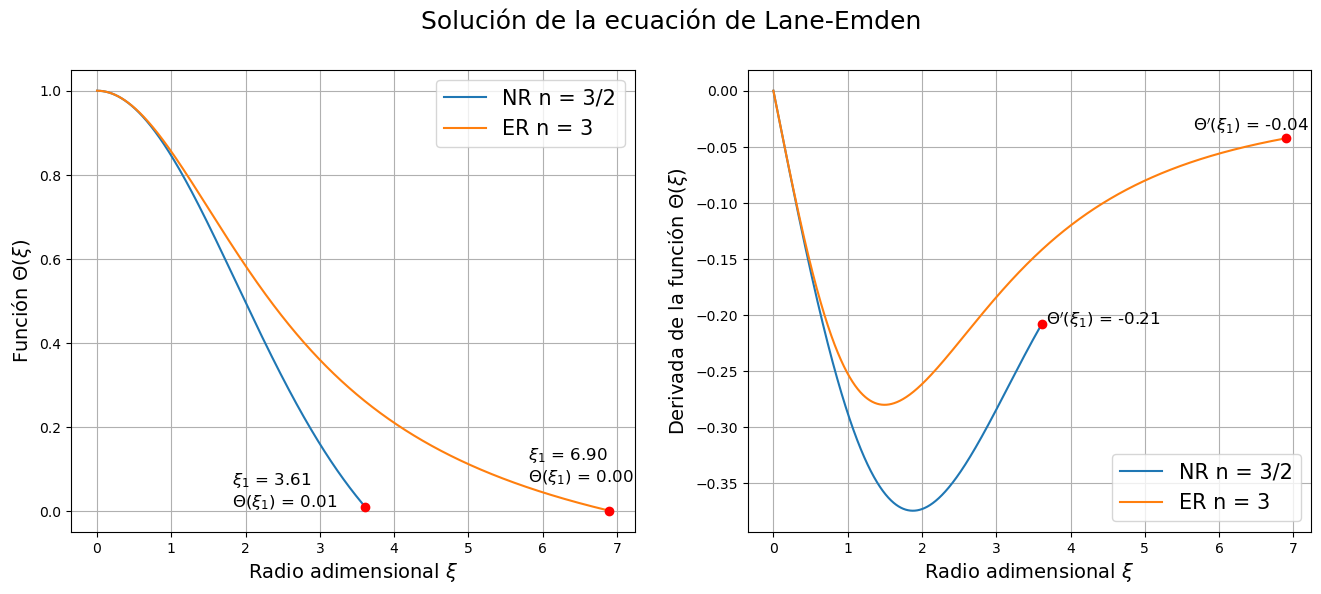

In [23]:
#Obtenemos el final de la estrella
fin_NR = final_estrella(y_NR)
fin_ER = final_estrella(y_ER)

# Graficamos las soluciones de y y z hasta el final de la estrella
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].plot(x[:fin_NR], y_NR[:fin_NR], label='NR n = 3/2')
ax[0].plot(x[:fin_ER], y_ER[:fin_ER], label='ER n = 3')
ax[0].set_xlabel('Radio adimensional $\\xi$')
ax[0].set_ylabel('Función $\\Theta(\\xi)$')
# ax[0].set_title('Solución de la ecuación de Lane-Emden')
ax[0].legend()
ax[0].grid()

ax[1].plot(x[:fin_NR], z_NR[:fin_NR], label='NR n = 3/2')
ax[1].plot(x[:fin_ER], z_ER[:fin_ER], label='ER n = 3')
ax[1].set_xlabel('Radio adimensional $\\xi$')
ax[1].set_ylabel('Derivada de la función $\\Theta(\\xi)$')
# ax[1].set_title('Solución de la ecuación de Lane-Emden')
ax[1].legend()
ax[1].grid()

# Indicamos los valores finales de xi (xi_1), theta y theta'
ax[0].plot(x[fin_NR], y_NR[fin_NR], 'ro')
ax[0].plot(x[fin_ER], y_ER[fin_ER], 'ro')
ax[0].text(x[fin_NR]-1.8, y_NR[fin_NR], f'$\\xi_1$ = {x[fin_NR]:.2f}\n$\\Theta(\\xi_1)$ = {y_NR[fin_NR]:.2f}', fontsize=12)
ax[0].text(x[fin_ER]-1.1, y_ER[fin_ER]+0.07, f'$\\xi_1$ = {x[fin_ER]:.2f}\n$\\Theta(\\xi_1)$ = {y_ER[fin_ER]:.2f}', fontsize=12)

ax[1].plot(x[fin_NR], z_NR[fin_NR], 'ro')
ax[1].plot(x[fin_ER], z_ER[fin_ER], 'ro')
ax[1].text(x[fin_NR]+0.06, z_NR[fin_NR], f'$\\Theta\'(\\xi_1)$ = {z_NR[fin_NR]:.2f}', fontsize=12)
ax[1].text(x[fin_ER]-1.25, z_ER[fin_ER]+0.007, f'$\\Theta\'(\\xi_1)$ = {z_ER[fin_ER]:.2f}', fontsize=12)

fig.suptitle('Solución de la ecuación de Lane-Emden')
plt.show()

